# Title and Introduction
# Text Chunking, Embedding, and Vector Store Indexing for CFPB Complaints

This notebook performs **Task 2** of the Intelligent Complaint Analysis project, processing the cleaned CFPB complaint dataset (`filtered_complaints.csv`, 470,118 rows) to create text chunks, generate vector embeddings, and index them in a vector store for the RAG pipeline. We address 4GB RAM constraints by processing in chunks and embedding in batches. We use `LangChain`’s `RecursiveCharacterTextSplitter`, `sentence-transformers/all-MiniLM-L6-v2`, and `ChromaDB`, with normalized metadata for traceability.

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')


In [7]:
drive.mount('/content/drive')
DATA_DIR = Path("/content/drive/MyDrive/filter")
VECTOR_STORE_DIR = Path("/content/drive/MyDrive/VectorMind-Chat/vector_store")
VECTOR_STORE_DIR.mkdir(parents=True, exist_ok=True)
dataset_path = DATA_DIR / "filtered_complaints.csv"
CHUNK_SIZE = 10000  # Adjusted for 4GB RAM

print(f"Loading dataset from {dataset_path}")
total_rows = sum(1 for _ in pd.read_csv(dataset_path, chunksize=CHUNK_SIZE))
print(f"Total Rows: {total_rows}")
df_head = pd.read_csv(dataset_path, nrows=5)
df_head

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading dataset from /content/drive/MyDrive/filter/filtered_complaints.csv
Total Rows: 48


,Complaint ID,ProductCategory,Issue,Company,Date received,cleaned_narrative,cleaned_length
0,14069121,Credit Cards,Getting a credit card,"CITIBANK, N.A.",2025-06-13,a card was opened under my name by a fraudster...,82
1,14061897,Savings Accounts,Managing an account,WELLS FARGO & COMPANY,2025-06-13,i made the mistake of using my wellsfargo debi...,105
2,14047085,Credit Cards,"Other features, terms, or problems","CITIBANK, N.A.",2025-06-12,"dear cfpb, i have a secured credit card with c...",155
3,14040217,Credit Cards,Incorrect information on your report,"CITIBANK, N.A.",2025-06-12,i have a citi rewards cards. the credit balanc...,224
4,13968411,Credit Cards,Problem with a purchase shown on your statement,"CITIBANK, N.A.",2025-06-09,bi am writing to dispute the following charges...,454


In [8]:
# Cell 4: Initialize Chunking and Embedding Models
## 1. Initialize Chunking and Embedding Models
# Set up text splitter and embedding model
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]
)
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("Initialized RecursiveCharacterTextSplitter (chunk_size=300, chunk_overlap=50) and all-MiniLM-L6-v2 model")

Initialized RecursiveCharacterTextSplitter (chunk_size=300, chunk_overlap=50) and all-MiniLM-L6-v2 model


Chunk size 200: 7745 chunks for 1000 narratives
Chunk size 300: 4841 chunks for 1000 narratives
Chunk size 500: 2932 chunks for 1000 narratives


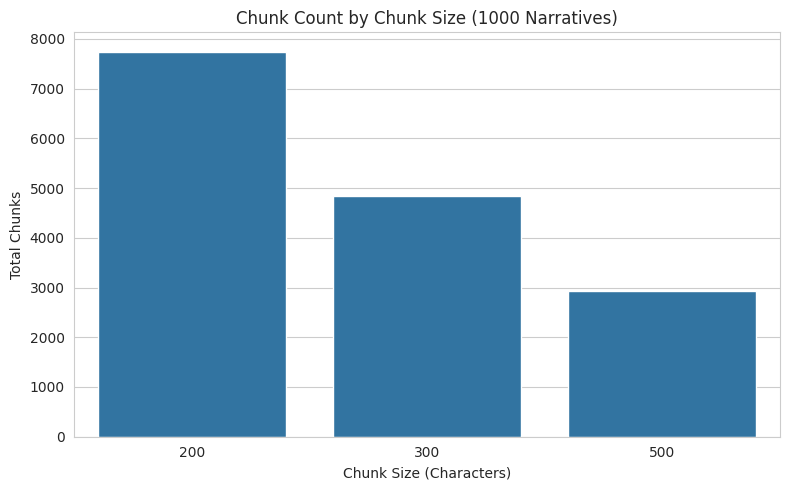

In [9]:
# Cell 5: Experiment with Chunk Sizes
## 2. Experiment with Chunk Sizes
# Test chunk sizes (200, 300, 500) on 1000 narratives
chunk_sizes = [200, 300, 500]
chunk_counts = []

for size in chunk_sizes:
    temp_splitter = RecursiveCharacterTextSplitter(
        chunk_size=size,
        chunk_overlap=50,
        length_function=len
    )
    sample_narratives = pd.read_csv(dataset_path, nrows=1000)['cleaned_narrative'].dropna().tolist()
    chunk_count = sum(len(temp_splitter.split_text(text)) for text in sample_narratives if text.strip())
    chunk_counts.append(chunk_count)
    print(f"Chunk size {size}: {chunk_count} chunks for 1000 narratives")

plt.figure(figsize=(8, 5))
sns.barplot(x=chunk_sizes, y=chunk_counts)
plt.title("Chunk Count by Chunk Size (1000 Narratives)")
plt.xlabel("Chunk Size (Characters)")
plt.ylabel("Total Chunks")
plt.tight_layout()
plt.savefig(VECTOR_STORE_DIR / "chunk_size_experiment.png")
plt.show()

In [ ]:
# Cell 6: Chunk and Embed Narratives
## 3. Chunk and Embed Narratives
# Process data chunks, create text chunks, and embed iteratively
from collections import Counter
import gc
from langchain_community.embeddings import HuggingFaceEmbeddings

def create_documents(narrative, metadata):
    if pd.isna(narrative) or not narrative.strip():
        return []
    chunks = text_splitter.split_text(narrative)
    return [Document(page_content=chunk, metadata=metadata) for chunk in chunks]

# Wrap the SentenceTransformer model in HuggingFaceEmbeddings for LangChain compatibility
# embedding_function = embedding_model.encode # Original line
embedding_function = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


vector_store = Chroma(
    collection_name="cfpb_complaints",
    embedding_function=embedding_function,
    persist_directory=str(VECTOR_STORE_DIR / "chroma_db")
)
total_chunks = 0
chunk_distribution = Counter()

for chunk_idx, chunk in enumerate(pd.read_csv(dataset_path, chunksize=CHUNK_SIZE)):
    chunk = chunk.dropna(subset=['cleaned_narrative'])
    documents = []
    for _, row in chunk.iterrows():
        metadata = {
            'complaint_id': str(row['Complaint ID']),
            'product_category': str(row['ProductCategory']),
            'issue': str(row['Issue'])[:100],
            'company': str(row['Company']),
            'date_received': str(row['Date received']),
            'source': 'cfpb'
        }
        docs = create_documents(row['cleaned_narrative'], metadata)
        documents.extend(docs)
        chunk_distribution.update([metadata['product_category'] for _ in docs])

    # Embed in batches and add to vector store
    batch_size = 50  # Reduced for memory efficiency
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]
        vector_store.add_documents(batch)
    total_chunks += len(documents)
    print(f"Chunk {chunk_idx + 1}: Processed {len(chunk)} rows, added {len(documents)} chunks")

    # Clear memory
    documents.clear()
    gc.collect()

vector_store.persist()
print(f"Total chunks created: {total_chunks}")
print("Chunk Distribution by Product Category:", dict(chunk_distribution))

/tmp/ipython-input-13-3889098582.py:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


Chunk 1: Processed 10000 rows, added 48003 chunks
Chunk 2: Processed 10000 rows, added 40523 chunks
